In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
#from analysis_scripts import *
import argparse
import os
import scipy.constants as cs
import sys
sys.path.append('../')
sys.path.append('../scripts/')
import mcg_gro as mcg_gro
import mcg_gro_nl_torch 
import pandas as pd
from matplotlib_config import colors
from scipy.fft import fft, fftfreq
import numpy as np
import mdtraj as md

In [2]:
phase = 'amorphous'
#phase = 'crystalline'

In [3]:
state_a = 10
state_b = 300

In [4]:
step2us = 2e-9

In [5]:
plt.rcParams.update({
    # 'font.family': 'sans-serif',
    # 'font.sans-serif': ['Arial', 'Helvetica', 'sans-serif'],
    'font.family': 'serif',  # Use a LaTeX-compatible serif font
    'font.serif': ['Computer Modern Roman'],  # Match LaTeX's default font
    'figure.figsize': (6.5, 4.5),
    'figure.dpi': 100,
    'text.usetex': True,
    'font.size': 18,
    'axes.labelsize': 20,
    'axes.titlesize': 16,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 16,
    'mathtext.default':'regular',
})


In [6]:
if phase == 'amorphous':
    folders = ["/leonardo_scratch/fast/L-AUT_Coretti/Haeupl/CriticalNucleus/Amorphous", "/leonardo_scratch/fast/L-AUT_Coretti/Haeupl/CriticalNucleus/Amorphous_old"]
elif phase == 'crystalline':
    folders = ["/leonardo_scratch/fast/L-AUT_Coretti/Haeupl/CriticalNucleus/Crystalline"]

In [7]:

# MCG_OP_results = []

# for sp_folder in os.listdir(folder):

#     sp_nr = int(sp_folder.split("_")[-1])
#     sp_folder_path = os.path.join(folder, sp_folder)
    
#     if os.path.isdir(sp_folder_path):
#         for sim_nr_folder in os.listdir(sp_folder_path):
            
#             sim_nr_folder_path = os.path.join(sp_folder_path, sim_nr_folder)
#             if os.path.isdir(sim_nr_folder_path):
#                 n = 50 
#                 outfile_path = os.path.join(sim_nr_folder_path, f"mcg_results_skip_{n}")

#                 with open(outfile_path, 'w') as outFile:
#                     # Write the header
#                     outFile.write(f"{'OG frame idx':<15}{'Frame':<10}{'Time (ps)':<20}{'MCG_OP':<15}\n")

#                     traj_file = os.path.join(sim_nr_folder_path, 'trajectory.h5')
                
#                     traj = md.load(traj_file, stride=n)
#                     original_frame_indices = np.arange(traj.n_frames) * n

#                     times_ps, CAR_COM_frames, WATER_COM_frames, box_lengths = mcg_gro_nl_torch.COM_calculation_mdtraj(traj)

                
#                     for idx, time_ps in enumerate(times_ps):
#                         CAR_COM = CAR_COM_frames[idx]
#                         WATER_COM = WATER_COM_frames[idx]
#                         box_length = box_lengths[idx]
#                         time_us = time_ps * 1e-6
                        
#                         frame = round(time_us / step2us)
                        
#                         # Assuming `MCG` takes these arguments and computes the order parameter
#                         MCG_OP, _, monomer_coords = mcg_gro.MCG(CAR_COM, WATER_COM, box_length, order=3, guest_cutoff=0.9)
#                         #np.savetxt( '../mcg_tests/monomers.xyz', monomer_coords)
#                         print(f'The largest cluster size in the system at frame {frame} and time {round(time_ps, 10)} is: {MCG_OP}')
#                         MCG_OP_results.append(MCG_OP)
#                         outFile.write(f"{original_frame_indices[idx]:<15}{frame:<10}{round(time_ps, 10):<20}{MCG_OP:<15.6f}\n")

In [8]:
data = {}

for folder_idx, folder in enumerate(folders):
    for sp_folder in os.listdir(folder):
    
        sp_folder_path = os.path.join(folder, sp_folder)
        if os.path.isdir(sp_folder_path):
            sp_nr = int(sp_folder.split("_")[-1])
            
            if sp_nr not in data:
                data[sp_nr] = {}
            
            if os.path.isdir(sp_folder_path):
                for sim_nr_folder in os.listdir(sp_folder_path):
                    
                    sim_nr_folder_path = os.path.join(sp_folder_path, sim_nr_folder)
                    if os.path.isdir(sim_nr_folder_path):
    
                        mcg_file = os.path.join(sim_nr_folder_path, 'mcg_results_skip_50')
                        
                        if os.path.isfile(mcg_file):
                            #print(sp_nr, sim_nr_folder)
                            
                            output_file = os.path.join(sim_nr_folder_path, 'output.csv')
                            
                            
                            step, epot, ekin, etot, temp, vol = np.loadtxt(output_file, skiprows=1, unpack=True, delimiter=",")
                            
                            _, frame, time_ps, mcg_value = np.loadtxt(mcg_file, skiprows=1, unpack=True)
                            
                            sim_nr = f'sim_nr_{int(sim_nr_folder.split("_")[-1])}_folder_{folder_idx}'
            
                            
                            data[sp_nr][sim_nr] = {
                                'step': step,
                                'epot': epot,
                                'ekin': ekin,
                                'etot': etot,
                                'temp': temp,
                                'vol': vol,
                                'mcg_step': frame,
                                'mcg': mcg_value
                            }

In [9]:
sp_list = sorted(data.keys())
print(sp_list)

[165, 170, 173, 175, 177, 180, 185]


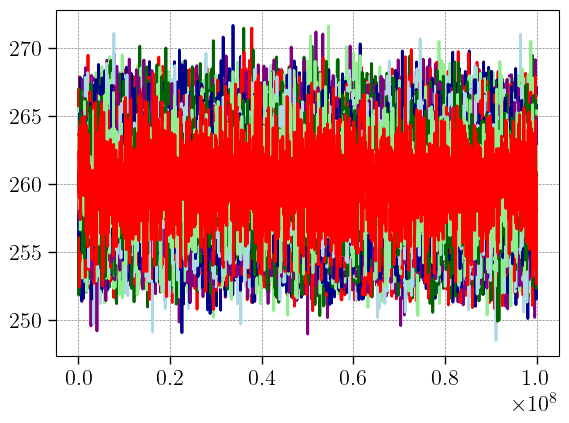

In [10]:
for sp in sp_list:
    for sim_nr in data[sp]:
        #print(sp, sim_nr)
        step = data[sp][sim_nr]['step']
        temp = data[sp][sim_nr]['temp']
        plt.plot(step,temp)

plt.show()

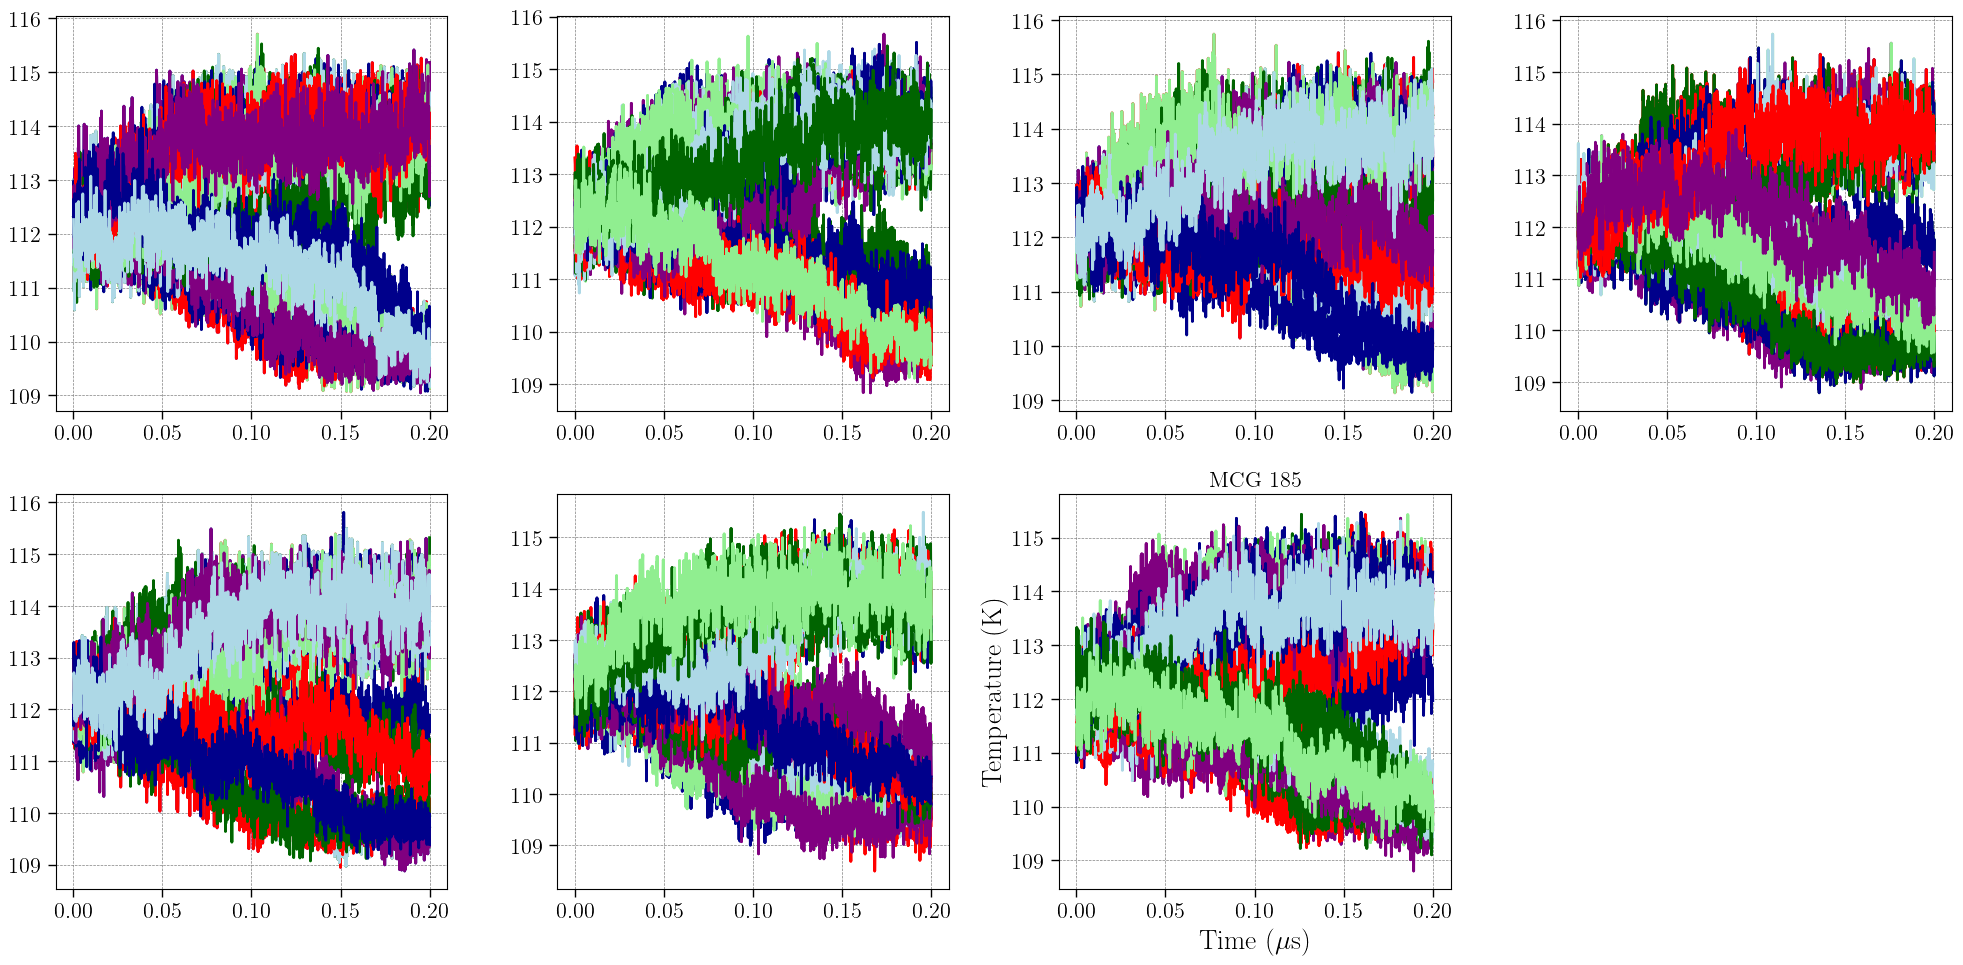

In [11]:
# Determine the number of rows and columns for the grid
n_species = len(sp_list)
n_cols = 4  # Number of columns in the grid (adjust as needed)
n_rows = (n_species + n_cols - 1) // n_cols  # Calculate the number of rows

# Create a figure with subplots in a grid layout
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(5 * n_cols, 5 * n_rows))

# Flatten the axs array for easy iteration (if n_rows > 1 or n_cols > 1)
if n_rows > 1 or n_cols > 1:
    axs = axs.flatten()
else:
    axs = [axs]  # Wrap in a list if there's only one subplot

# Iterate over each species and create a subplot
for folder in folders:
    for i, sp in enumerate(sp_list):
        ax = axs[i]  # Get the current subplot axis
        for sim_nr in data[sp]:
            step = data[sp][sim_nr]['step']
            #print(step)
            temp = data[sp][sim_nr]['vol']
            ax.plot(step*step2us, temp, label=f'{sim_nr}')
            #ax.set_ylim(240, 280)
    
    # Add labels, title, and legend to the subplot
    ax.set_xlabel(r"Time ($\mu$s)")
    ax.set_ylabel('Temperature (K)')
    ax.set_title(f'MCG {sp}')
    #ax.legend(ncol=5, fontsize=10)
    ax.grid(True)

# Hide empty subplots (if any)
for j in range(i + 1, n_rows * n_cols):
    axs[j].axis('off')  # Turn off unused subplots

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [12]:
plt.rcParams.update({
    # 'font.family': 'sans-serif',
    # 'font.sans-serif': ['Arial', 'Helvetica', 'sans-serif'],
    'font.family': 'serif',  # Use a LaTeX-compatible serif font
    'font.serif': ['Computer Modern Roman'],  # Match LaTeX's default font
    'figure.figsize': (6.5, 4.5),
    'figure.dpi': 100,
    'text.usetex': True,
    'font.size': 25,
    'axes.labelsize': 25,
    'axes.titlesize': 25,
    'xtick.labelsize': 25,
    'ytick.labelsize': 25,
    'legend.fontsize': 25,
    'mathtext.default':'regular',
})

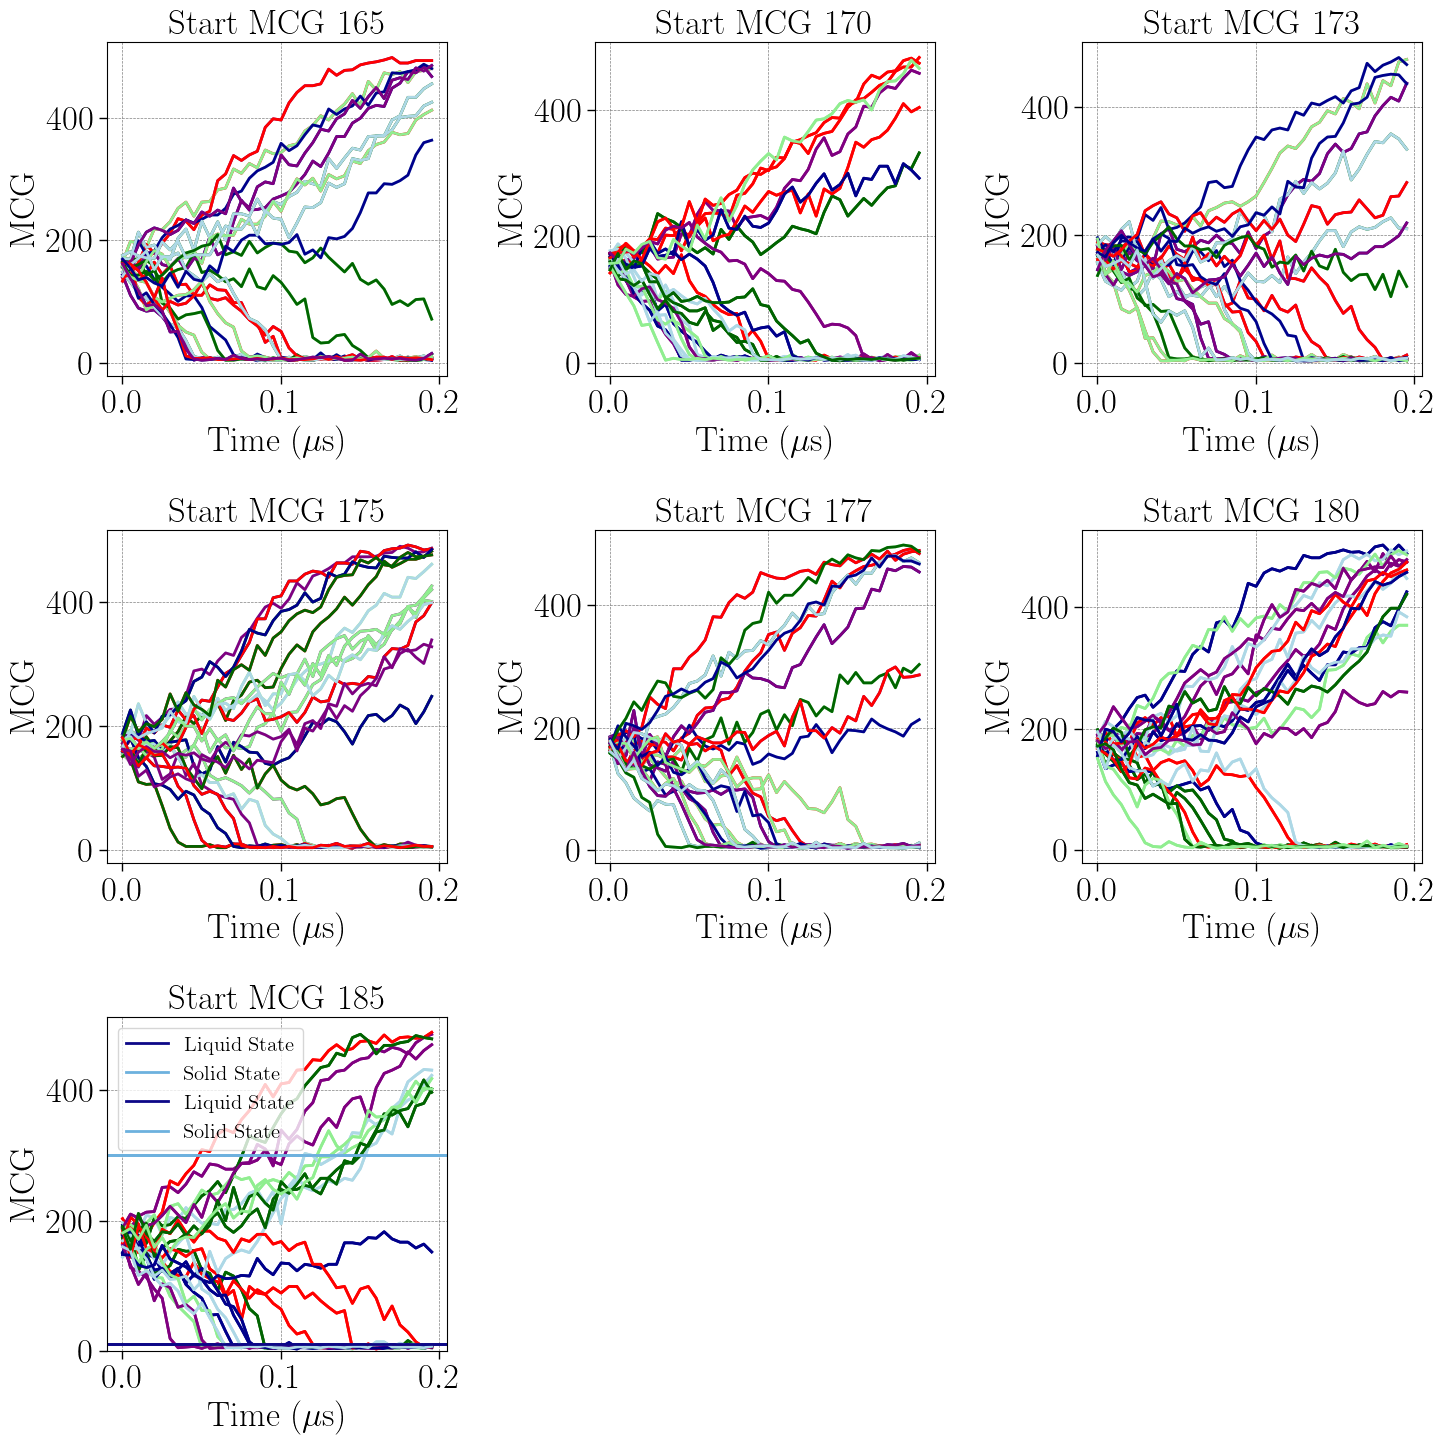

In [13]:
# Determine the number of rows and columns for the grid
n_species = len(sp_list)
n_cols = 3  # Number of columns in the grid (adjust as needed)
n_rows = (n_species + n_cols - 1) // n_cols  # Calculate the number of rows

# Create a figure with subplots in a grid layout
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(5 * n_cols, 5 * n_rows))

cmap = plt.cm.plasma  # You can change this to any other colormap
colors_plt = cmap(np.linspace(0, 1, len(data[sp])))  # Generate a color cycle from the colormap

# Set the color cycle globally using rcParams
plt.rcParams.update({'axes.prop_cycle': plt.cycler('color', colors_plt)})


# Flatten the axs array for easy iteration (if n_rows > 1 or n_cols > 1)
if n_rows > 1 or n_cols > 1:
    axs = axs.flatten()
else:
    axs = [axs]  # Wrap in a list if there's only one subplot

# Iterate over each species and create a subplot
for folder in folders:
    for i, sp in enumerate(sp_list):
        ax = axs[i]  # Get the current subplot axis
        for sim_nr in data[sp]:        
            step = data[sp][sim_nr]['mcg_step']
            mcg = data[sp][sim_nr]['mcg']
            ax.plot(step*step2us, mcg)
        
        # Add labels, title, and legend to the subplot
        ax.set_xlabel(r"Time ($\mu$s)")
        ax.set_ylabel('MCG')
        ax.set_title(f'Start MCG {sp}')
    ax.axhline(state_a, label = 'Liquid State')
    ax.axhline(state_b, label = 'Solid State', color = colors['lightblue'])
    ax.legend(fontsize=15)
    ax.set_ylim(0, 512)
    ax.grid(True)

# Hide empty subplots (if any)
for j in range(i + 1, n_rows * n_cols):
    axs[j].axis('off')  # Turn off unused subplots

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot

plt.savefig(f"{folder}/CA_trajectories.png", bbox_inches='tight', dpi=300)  # Increase DPI as needed
plt.show()

In [14]:
def state_definition(last_mcg):
    if last_mcg <= 10:
        return 'A'
    elif last_mcg >= 300:
        return 'B'

In [15]:
def state_definition_flexible(mcg):    
    if np.sum(mcg < state_a) > 0:
        return 'A'
    elif np.sum(mcg > state_b) > 0:
        return 'B'
    #else:
    #    return '0'

In [16]:
def state_definition_fixed(mcg):    
    if mcg[-1] < state_a:
        return 'A'
    elif mcg[-1] > state_b:
        return 'B'
    #else:
    #    return '0'

In [17]:
state_ratio_arr = np.zeros(len(sp_list))
state_ratio_std_arr = np.zeros(len(sp_list))

for idx, sp in enumerate(sp_list):
    state_definitions = []
    for sim_nr in data[sp].keys():
        step = data[sp][sim_nr]['mcg_step']
        mcg = data[sp][sim_nr]['mcg']

        # state = state_definition(mcg[-1])
        state = state_definition_flexible(mcg)
        state_definitions.append(state)
    state_definitions = [x for x in state_definitions if x is not None]
    state_definitions = np.array(state_definitions)
    in_state_a = state_definitions == "A"
    in_state_b = state_definitions == "B"
    #print(in_state_a)

    
    state_ratio = np.mean(in_state_b)
    #state_ratio = in_state_b.sum() / (in_state_b.sum() + in_state_a.sum())
    state_ratio_std = np.std(in_state_b)
    state_ratio_arr[idx] = state_ratio
    state_ratio_std_arr[idx] = state_ratio_std / np.sqrt(len(state_definitions)-1)

In [18]:
state_ratio_arr = np.zeros(len(sp_list))
state_ratio_std_arr = np.zeros(len(sp_list))

# New function for blocking analysis
def blocking_analysis(data, min_blocks=4, max_blocks=20):
    """Calculate standard error using blocking method"""
    n = len(data)
    block_errors = []
    
    # Try different block sizes
    for nblocks in range(min_blocks, min(max_blocks, n//2)):
        blocks = np.array_split(data, nblocks)
        block_means = [np.mean(block) for block in blocks]
        block_var = np.var(block_means, ddof=1)  # Sample variance
        block_error = np.sqrt(block_var / nblocks)
        block_errors.append(block_error)
    
    # Use maximum error estimate (conservative)
    return np.max(block_errors) if block_errors else 0

for idx, sp in enumerate(sp_list):
    state_definitions = []
    # ==== CHANGE: Collect all trajectory states first ====
    for sim_nr in data[sp].keys():
        step = data[sp][sim_nr]['mcg_step']
        mcg = data[sp][sim_nr]['mcg']
        state = state_definition_flexible(mcg)
        state_definitions.append(state)
    
    # Filter and convert to array
    state_definitions = [x for x in state_definitions if x is not None]
    state_definitions = np.array(state_definitions)
    
    # ==== CHANGE: Create numeric array for blocking ====
    state_numeric = np.where(state_definitions == "B", 1, 0)
    
    state_ratio = np.mean(state_numeric)
    state_ratio_arr[idx] = state_ratio
    
    # ==== KEY CHANGE: Use blocking instead of naive std ====
    if len(state_numeric) > 1:
        state_ratio_std = blocking_analysis(state_numeric)
    else:
        state_ratio_std = 0
        
    state_ratio_std_arr[idx] = state_ratio_std

In [19]:
plt.rcParams.update({
    # 'font.family': 'sans-serif',
    # 'font.sans-serif': ['Arial', 'Helvetica', 'sans-serif'],
    'font.family': 'serif',  # Use a LaTeX-compatible serif font
    'font.serif': ['Computer Modern Roman'],  # Match LaTeX's default font
    'figure.figsize': (6.5, 4.5),
    'figure.dpi': 300,
    'text.usetex': True,
    'font.size': 18,
    'axes.labelsize': 20,
    'axes.titlesize': 16,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 16,
    'mathtext.default':'regular',
})


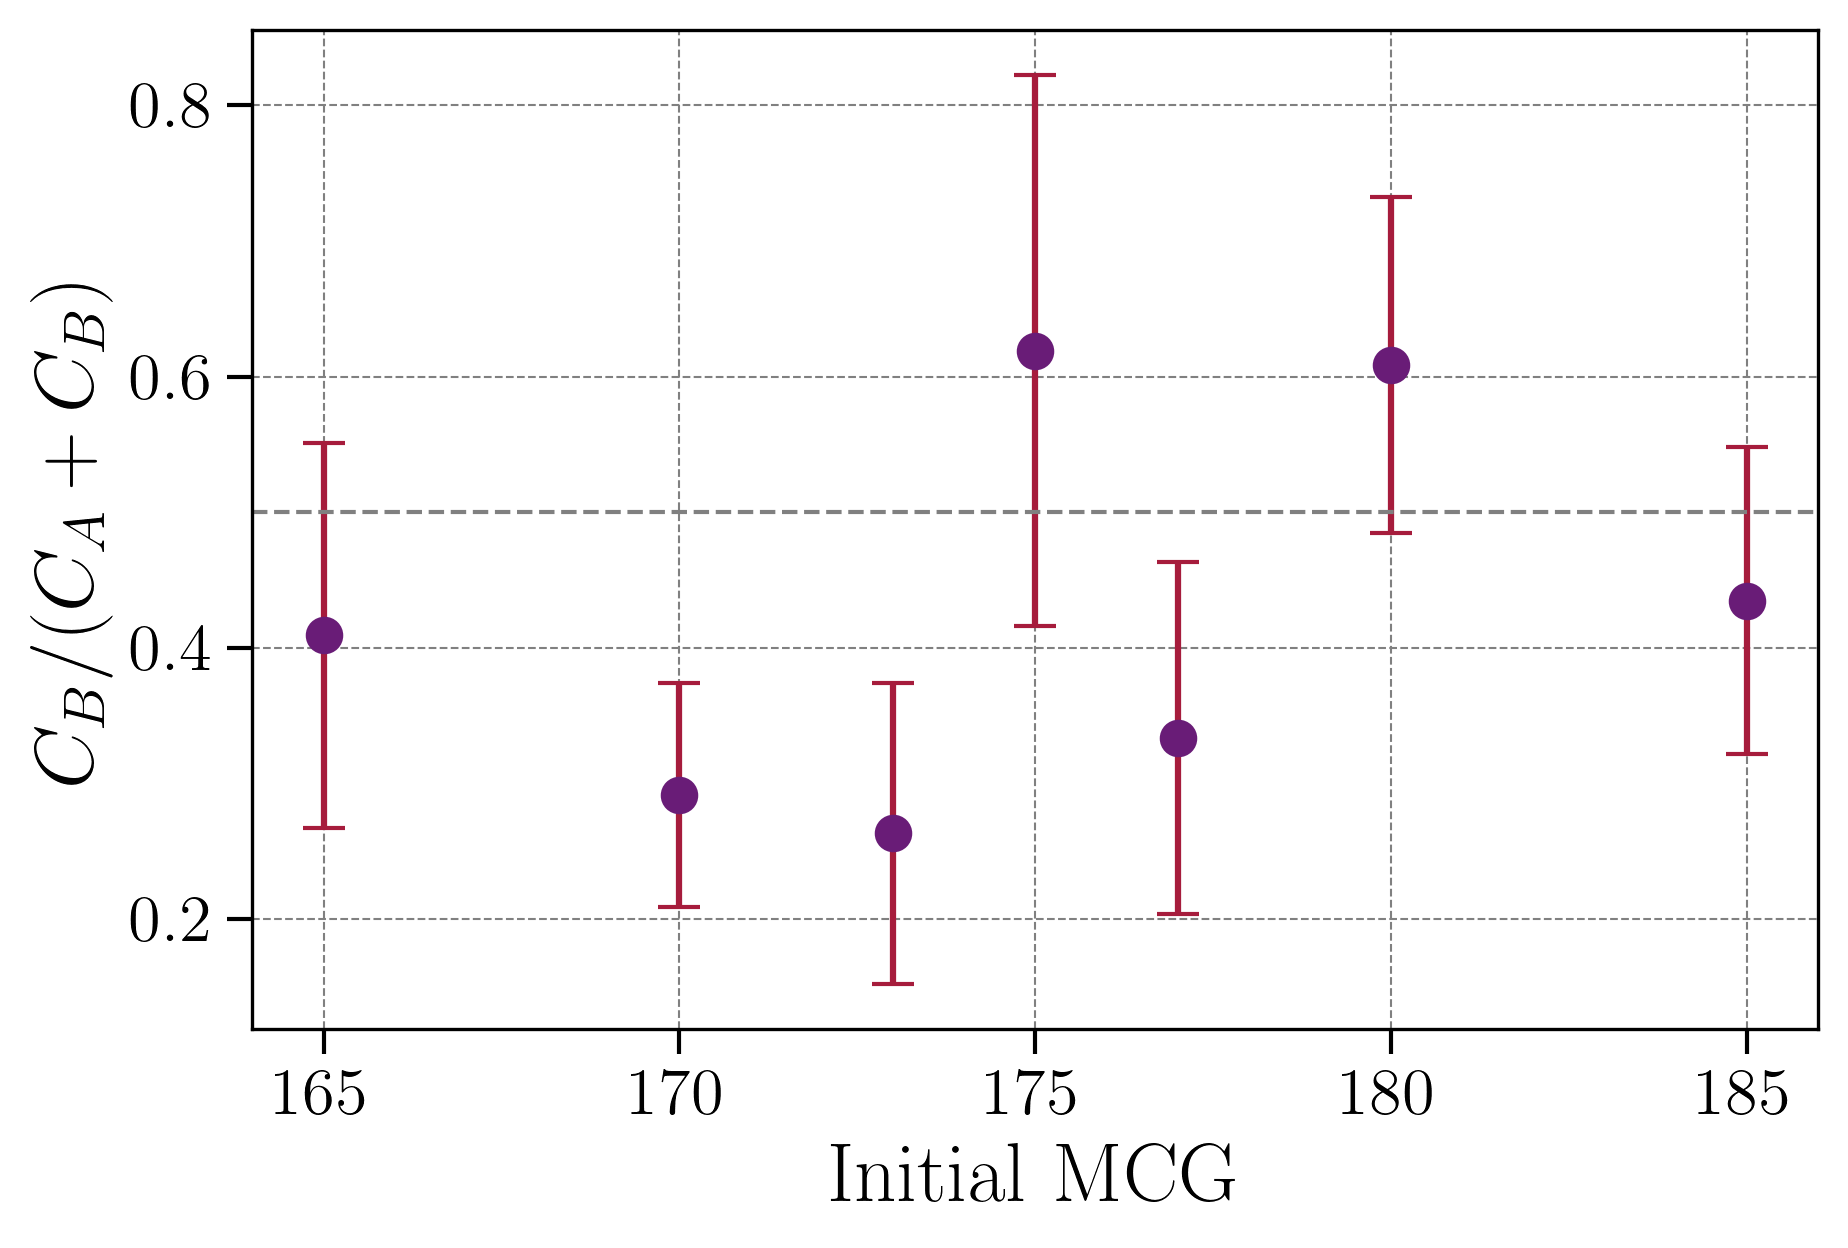

In [21]:
plt.errorbar(sp_list, state_ratio_arr, yerr=state_ratio_std_arr, fmt='o', capsize=5, label="Data", color = colors['purple'], ecolor=colors['red'],elinewidth=1.5)
plt.xlabel("Initial MCG")
plt.ylabel(r"$C_B / ( C_A + C_B)$")
plt.tight_layout()
plt.axhline(0.5, c = 'grey', linestyle = '--', lw = 1)
plt.savefig(f"../figures/CriticalNucleus/state_ratio_260_{phase}.png")